# Facies classification using machine learning
#### Joshua Poirier, [NEOS](https://www.neosgeo.com/)
2016 SEG Machine Learning Competition  

## Introduction

This notebook demonstrates a novel way of training a machine learning algorithm to predict facies from well log data. The data set we use comes from a class exercise from The University of Kansas on Neural Networks and Fuzzy Systems. This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields.  

The data set we will use contains log data from nine wells that have been labeled with a facies type based on core examination. I use this log data to train support vector machine (SVM) classifiers to predict the facies type. SVM's are a type of supervised learning algorithm which can be trained on data to perform classification and regression. The SVM algorithm uses the training data to fit an optimal hyperplane between the different classes (in our case - facies). 

My approach is to build multiple models and allow them to **vote** - this process is called **blended modeling**. The novelty in my approach is that I build a model for each well in the training data and weight it based on its cross-correlation with the well of interest. This is intended to re-introduce some spatial geometry to the problem. Wells closer to the well of interest are more likely to exhibit a similar log character. Cross-correlation between close wells should show smaller lag and higher maximum correlation. Furthermore, the lag may be used to pre-process the **RELPOS** (relative position) channel - enhancing the predictive nature of that feature.  

To get started, let's load the libraries and supporting files!

In [1]:
# supporting visualization libraries
library(repr)
library(ggplot2)
library(ggthemes)
library(cowplot)

# libraries and supporting files
library(e1071)
library(caret)

Warning message:
"package 'repr' was built under R version 3.2.5"Warning message:
"package 'cowplot' was built under R version 3.2.5"
Attaching package: 'cowplot'

The following object is masked from 'package:ggplot2':

    ggsave

Warning message:
"package 'e1071' was built under R version 3.2.5"Warning message:
"package 'caret' was built under R version 3.2.5"Loading required package: lattice


## 2 Loading and splitting the data  

Blahblahblah

In [2]:
# function to load data
loadData <- function() {
    fname <- "../facies_vectors.csv"
    data <- read.csv(fname, colClasses=c(rep("factor",3), rep("numeric",6), "factor", "numeric"))
    
    data
}

In [3]:
# function to pre-process the data
preProcessData <- function(data) {
    # convert NM_M channel into a binary channel "isMarine"
    data$NM_M <- data$NM_M == "2"
    names(data)[10] <- "isMarine"

    # make the Facies channel more descriptive
    levels(data$Facies) <- c("SS", "CSiS", "FSiS", "SiSh", "MS", "WS", "D", "PS", "BS")
    
    data
}

In [4]:
# function to split the data
splitData <- function(data, testWell) {
    testIndex <- data$Well.Name == testWell
    
    train <- data[!testIndex,]
    test <- data[testIndex,]
    split <- list(train, test)
    
    split
}

In [5]:
# load and pre-process the data
data <- loadData()
data <- preProcessData(data)

# split the data
split <- splitData(data, "SHANKLE")
train <- split[[1]]
test <- split[[2]]
rm(split)

"Training Data"
head(train)

"Testing Data"
head(test)

[1] "Training Data"

Facies,Formation,Well.Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,isMarine,RELPOS
FSiS,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,FALSE,1.000
FSiS,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,FALSE,0.979
FSiS,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,FALSE,0.957
FSiS,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,FALSE,0.936
FSiS,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,FALSE,0.915
FSiS,A1 SH,SHRIMPLIN,2795.5,73.97,0.636,14.0,13.385,3.6,FALSE,0.894


[1] "Testing Data"

,Facies,Formation,Well.Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,isMarine,RELPOS
938,CSiS,A1 SH,SHANKLE,2774.5,98.36,0.642,-0.1,18.685,2.9,FALSE,1.000
939,CSiS,A1 SH,SHANKLE,2775.0,97.57,0.631,7.9,16.745,3.2,FALSE,0.984
940,CSiS,A1 SH,SHANKLE,2775.5,98.41,0.615,12.8,14.105,3.2,FALSE,0.968
941,CSiS,A1 SH,SHANKLE,2776.0,85.92,0.597,13.0,13.385,3.4,FALSE,0.952
942,CSiS,A1 SH,SHANKLE,2776.5,83.16,0.592,12.3,13.345,3.4,FALSE,0.935
943,CSiS,A1 SH,SHANKLE,2777.0,82.56,0.599,12.9,13.105,3.5,FALSE,0.919


## 3 Exploratory Data Analysis  

Blahblahblah  

### 3.1 Function building and testing  

To properly perform exploratory data analysis (and subsequent model tuning, training, and testing) we will need to build a few functions. Here, we'll build some functions and test them with simulated data.  

#### 3.1.1 Centering and scaling data  

Centering and scaling data is common practice in machine learning applications.  Considering our well problem, it's no stretch to imagine that the log responses between two wells may be similar; however, they may be offset or have different sensitivities.  This may result from imperfect instrument calibration, different vintages of data, or even geologic noise.  For our problem of predicting facies we want to remove these effects as much as possible.  As such, we center and scale *numeric* data - classification data are not centered or scaled (such as our **isMarine** feature) as that just wouldn't make sense!

In [6]:
# function to center/scale data
# user may supply toScale, logical vector informing which columns are to be scaled
# toScale vector length must be same as the number of columns in data dataframe
centerScaleData <- function(data, toScale=NULL) {
   
    # if given toScale is "ALL" - create vector filled with trues
    if (is.null(toScale)) {
        toScale <- rep(T, ncol(data))
    } 
    
    try ((if (!(length(toScale == ncol(data)))) stop("Error! 'data' # columns not equal to 'toScale' logical vector length.")))
    
    # for each numeric feature in the data frame, center and scale
    for (i in 1:length(toScale)) {
        if (toScale[i]) {
            data[,i] <- scale(data[,i])
        }
    }
    
    data
}

Now let's test this function to ensure it's working. I'll simulate some data and apply the function.

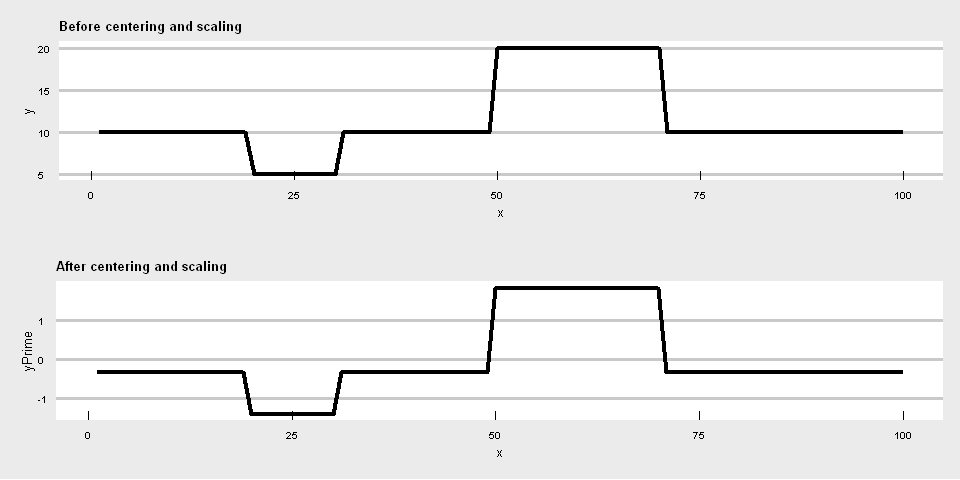

In [7]:
# simulate x and y data
x <- 1:100
y <- rep(10, 100)
y[20:30] <- 5
y[50:70] <- 20

# build data frame with yPrime as the center and scaled 'y' data
simData <- data.frame(x, y, centerScaleData(as.data.frame(y)))
names(simData) <- c("x", "y", "yPrime")

options(repr.plot.width=8, repr.plot.height=4)

# plot before centering and scaling
g1 <- ggplot(simData, aes(x=x, y=y)) + theme_economist_white(gray_bg=T) +
        labs(title="Before centering and scaling") +
        geom_line(size=1.2) +
        theme(axis.text=element_text(size=6), axis.title=element_text(size=8), plot.title=element_text(size=8))

# plot after centering and scaling
g2 <- ggplot(simData, aes(x=x, y=yPrime)) + theme_economist_white(gray_bg=T) +
        labs(title="After centering and scaling") +
        geom_line(size=1.2) +
        theme(axis.text=element_text(size=6), axis.title=element_text(size=8), plot.title=element_text(size=8))

# bring plots together in one figure
g <- plot_grid(g1, g2, ncol=1)
ggdraw() + draw_plot(g, width=1, height=1)

Notice how *after* the centering and scaling the data is centered around **zero** and has a much smaller range compared to *before*. Looks good, now let's move on!  

#### 3.1.2 Cross-correlation  

Cross-correlation measures well two data sets (time series) resemble each other.  If the two sets are offset from each other, they will show **maximum correlation** at that offset, or **lag**.  For our problem, we may be able to exploit cross-correlation to weight the data going into the predictive models. Data from wells closer to the test well are likely to be more predictive than data from wells farther from the test well due to having a similar depositional environment and having undergone similar geologic processes post-deposition.  

We may be able to leverage cross-correlation to come up with a proxy for this similarity.  The **maximum correlation** and **lag** may approximate this similarity.  My thesis in this notebook is that log profiles which are most similar and least offset are most predictive.  

Before we get there, we must build a cross-correlation function and test it!

In [8]:
# function to perform crosscorrelation between two vectors
crossCorrelate <- function(a, b) {
    
    # calculate cross-correlation between vectors a and b
    ccor <- ccf(a, b, lag.max=400, plot=F)

    # retrieve the maximum correlation and associated lag
    corr <- max(ccor[["acf"]][,,1])
    lag <- ccor[["lag"]][,,1][which.max(ccor[["acf"]][,,1])]
    
    # return maximum correlation and associated lag
    list(correlation=corr, lag=lag)
}

Now let's simulate some data and test the function!  My two 20-pt anomalies will occur 30-pts offset from each other.  Can cross-correlation resolve this?

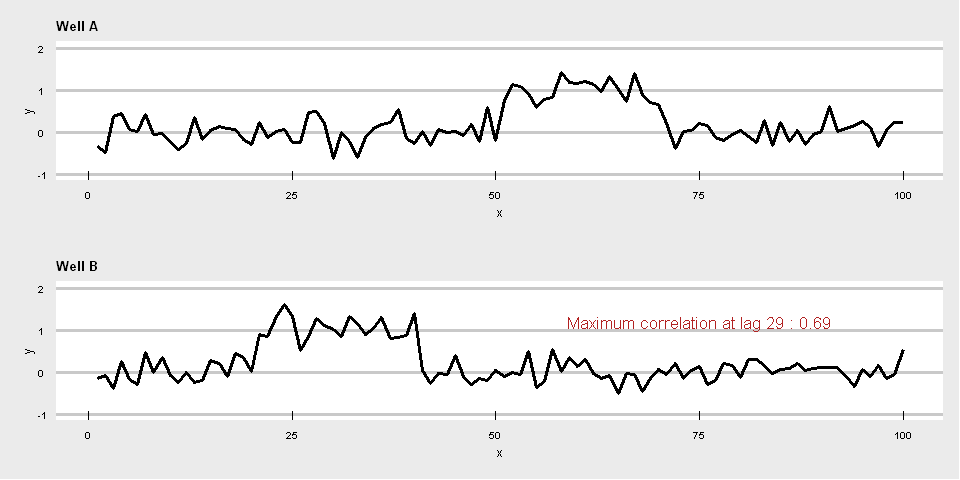

In [9]:
# basic plotting function
plotSimLog <- function(data, plotTitle) {
    g <- ggplot(data, aes(x=x, y=y)) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(-1,2)) +
        labs(title=plotTitle) +
        geom_line(size=1) +
        theme(axis.text=element_text(size=6), axis.title=element_text(size=8), plot.title=element_text(size=8))
    g
}

set.seed(3124)

# simulate some offset data
a <- c(rep(0, 50), rep(1, 20), rep(0,30)) + rnorm(100,0,.25)
b <- c(rep(0, 20), rep(1, 20), rep(0,60)) + rnorm(100,0,.25)
ccorr <- crossCorrelate(a, b)

# build plots of two simulated wells
options(repr.plot.width=8, repr.plot.height=4)

dfA <- data.frame(x=1:100, y=a)
dfB <- data.frame(x=1:100, y=b)
ga <- plotSimLog(dfA, "Well A")
gb <- plotSimLog(dfB, "Well B") +
        geom_text(aes(x=75, y=1.2, 
                      label=paste("Maximum correlation at lag", ccorr$lag, ":", round(ccorr$correlation,2)))
                  , size=3.5, col="firebrick")
g <- plot_grid(ga, gb, ncol=1)
ggdraw() + draw_plot(g, width=1, height=1)

There we have it, even with noise added cross-correlation resolves a **lag** of **29** compared to the true offset of 30.  Now let's apply this lag to **Well B** to try and make it line up with **Well A**.

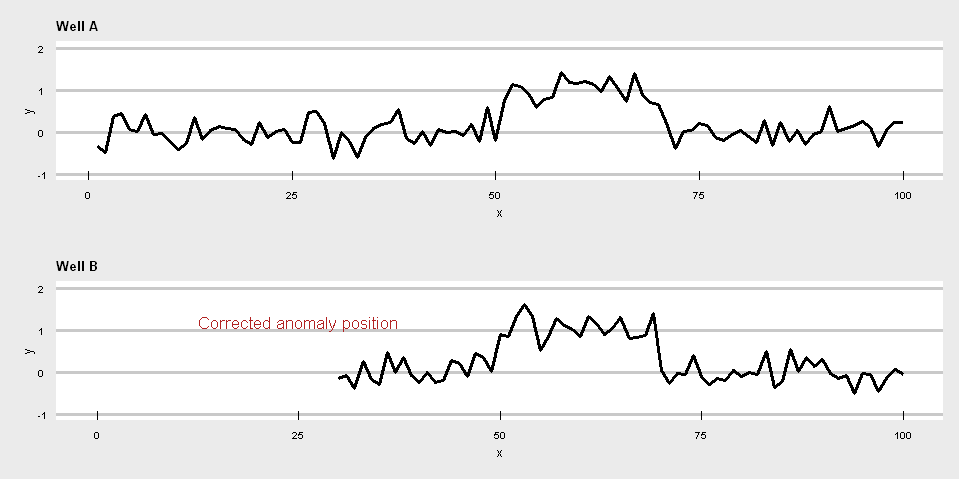

In [10]:
dfB2 <- dfB
dfB2$x <- dfB$x + ccorr$lag

ga <- plotSimLog(dfA, "Well A")
gb <- plotSimLog(dfB2[dfB2$x <= 100,], "Well B") +
        scale_x_continuous(lim=c(0,100)) +
        geom_text(aes(x=25, y=1.2, 
                      label="Corrected anomaly position")
                  , size=3.5, col="firebrick") 
g <- plot_grid(ga, gb, ncol=1)
ggdraw() + draw_plot(g, width=1, height=1)

#### 3.1.3 Looping across features  

It would be useful to have a function which can loop across several features in a pair of data frames and apply a given function.  So let's build one!

In [11]:
# apply a function "FUN" over columns of data frames "a" and "b"
# NOTE: FUN must take two arguments, two vectors of data
loopAcrossFeatures <- function(a, b, features, FUN) {
    
    # get list of columns for a and b dataframes
    features_a <- names(a)[names(a) %in% features]
    features_b <- names(b)[names(b) %in% features]
    
    # ensure a and b data frames have the same features
    try ((if (!all.equal(features_a, features_b)) stop("Error! Data frames do not have the same features.")))
    
    # initialize resulting data frame
    r <- data.frame()
    
    # loop through features
    for (feature in features) {
        # retrieve the feature vector of interest from each data frame
        av <- as.data.frame(a[,which(names(a) %in% feature)])
        bv <- as.data.frame(b[,which(names(b) %in% feature)])
        
        # apply the function to the two features, storing in a data frame
        temp <- as.data.frame(FUN(av, bv))
        temp$feature <- feature
       
        # merge result with those of other features
        r <- rbind(temp,r)
    }
    
    r
}

Now let's test this function by applying our cross-correlation function to a pair of data frames containing simulated data!  The data simulated will have a 20-pt anomaly offset by 30-pt's between the two data sets.

In [12]:
set.seed(456)

# simulate some data
x <- 1:100
a <- c(rep(0,50), rep(1,20),rep(0,30))
b <- c(rep(0,20), rep(1,20),rep(0,60))

# build data frames using simulated data - add increasing amount of noise to 'a' and 'b' vectors as features
df1 <- data.frame(x=x, sm_noise=a+rnorm(100,0,.01), md_noise=a+rnorm(100,0,.1), lg_noise=a+rnorm(100,0,1))
df2 <- data.frame(x=x, sm_noise=b+rnorm(100,0,.01), md_noise=b+rnorm(100,0,.1), lg_noise=b+rnorm(100,0,1))

# loop across the features in the data frame
loopAcrossFeatures(df1, df2, c("sm_noise", "md_noise", "lg_noise"), crossCorrelate)

correlation,lag,feature
0.2759573,37,lg_noise
0.8603389,30,md_noise
0.9243086,30,sm_noise


Interesting!  This shows two things: A) our function is working, and B) with increasing the noise we get lower correlation and potentially incorrect **lag** (compared to the correct value of 30).  Something to keep in mind during the application of these functions moving forward.  

In [13]:
# function looks at the training data and determines which of the relevant testFeatures it includes
# returns list of features which can be used for training or weighting models
# NOTE: VERY IMPORTANT that given test well has data for all features listed in testFeatures RE: PE feature
whichFeatures <- function(train, testFeatures) {
    
    # ensure features have actual data
    goodFeatures <- names(train)[!is.na(train[1,])]
    
    # certain features we're just not interested in modeling
    badFeatures <- c("Formation", "Well.Name", "Depth")
    if (sum(train$Well.Name == "Recruit F9") == nrow(train)) badFeatures <- c(badFeatures, "RELPOS")
    goodFeatures <- goodFeatures[!goodFeatures %in% badFeatures]

    # finally, we only want to include features which also exist in the test data set
    goodFeatures <- goodFeatures[goodFeatures %in% testFeatures]

    goodFeatures
}

crossCorrData <- function(train, test) {
    
    # initialize weights list
    crossCorrs <- data.frame(trainWell=factor(), testWell=factor(), feature=factor(), correlation=numeric(), lag=numeric())
    
    # retrieve list of wells in training set, and what features are in the test data
    trainWells <- unique(train$Well.Name)
    testFeatures <- names(test)[!is.na(test[1,])]
    testToScale <- testFeatures %in% testFeatures[!testFeatures %in% 
                                                  c("Facies", "Formation", "Well.Name", "Depth", "RELPOS", "isMarine")]
    
    # loop through training wells
    for (well_i in trainWells) {
        # subset the data
        train_i <- train[train$Well.Name == well_i,]
        
        # which features to scale
        trainFeatures <- whichFeatures(train_i, testFeatures)
        trainToScale <- names(train_i) %in% trainFeatures & !names(train_i) %in% c("Facies", "Depth", "isMarine", "RELPOS")
        
        # calculate cross-correlation for each feature between current training well and testing well
        temp <- loopAcrossFeatures(centerScaleData(train_i, trainToScale), centerScaleData(test, testToScale),
                                   trainFeatures, crossCorrelate)
        temp$trainWell <- well_i
        temp$testWell <- test$Well.Name[1]
        
        # add current wells cross-correlation metrics to the data frame
        crossCorrs <- rbind(crossCorrs, temp)
    }
    
    crossCorrs
}

In [14]:
buildPlot <- function(data, plotTitle) {

    # build correlation plot
    gc <- ggplot(data, aes(feature, trainWell, fill=correlation)) + theme_economist_white(gray_bg=T) +
            geom_raster(alpha=.8) +
            labs(x="", y="Well", title=plotTitle) +
            scale_fill_distiller(palette="Spectral", name="", direction=-1, lim=c(0.15, 0.8)) +
            theme(legend.position="right",
                  plot.title=element_text(size=8), 
                  axis.text=element_text(size=6),
                  axis.text.x=element_text(size=6, angle=90),
                  axis.title=element_text(size=8),
                  legend.text=element_text(size=8))
    
    # return the plots
    gc
}

### 3.2 Cross-correlation by feature  

Different features (**GR**, **ILD_log10**, etc.) may exhibit different cross-correlation results.  I'll now loop through the training data wells and treat each iterated well as the *test* well.  We'll apply cross-correlation with the remaining wells and average their peak correlations to see which features are most correlative.  

We will also (temporarily) discard the **Recruit F9** *well*.  This data does not represent an actual well; rather, curated data points for the facies **Phylloid-algal bafflestone** - so we'll treat it specially later.

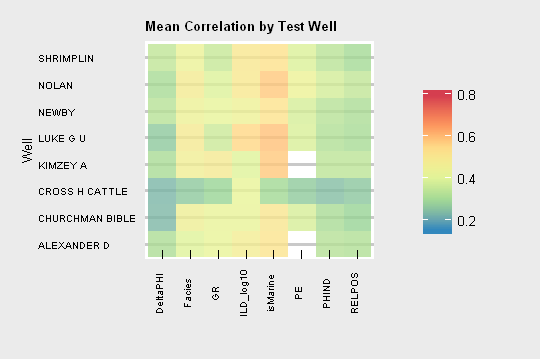

In [15]:
trainLoop <- train[train$Well.Name != "Recruit F9",]
wells <- unique(trainLoop$Well.Name)
weights <- data.frame()

for (well_i in wells) {
    split <- splitData(trainLoop, well_i)
    atrain <- split[[1]]
    atest <- split[[2]]
    
    weights <- rbind(weights, crossCorrData(atrain, atest))
}

agg <- aggregate(correlation ~ feature + testWell, data=weights, FUN=mean)
names(agg) <- c("feature", "trainWell", "correlation")

options(repr.plot.width=4.5, repr.plot.height=3)
plt <- buildPlot(agg, "Mean Correlation by Test Well")
plt

From this, we see that the **isMarine** feature appears most correlative between wells followed by **ILD_log10**.  Since this is an aggregate plot, let's break this up to be thorough and look at the correlations for each well against the others for each feature. Similarly, the **CROSS H CATTLE** well appears to consistently have poorer correlation than other wells.  If we were trying to predict values from any other well, it would be logical to weight this wells data lower than the others!

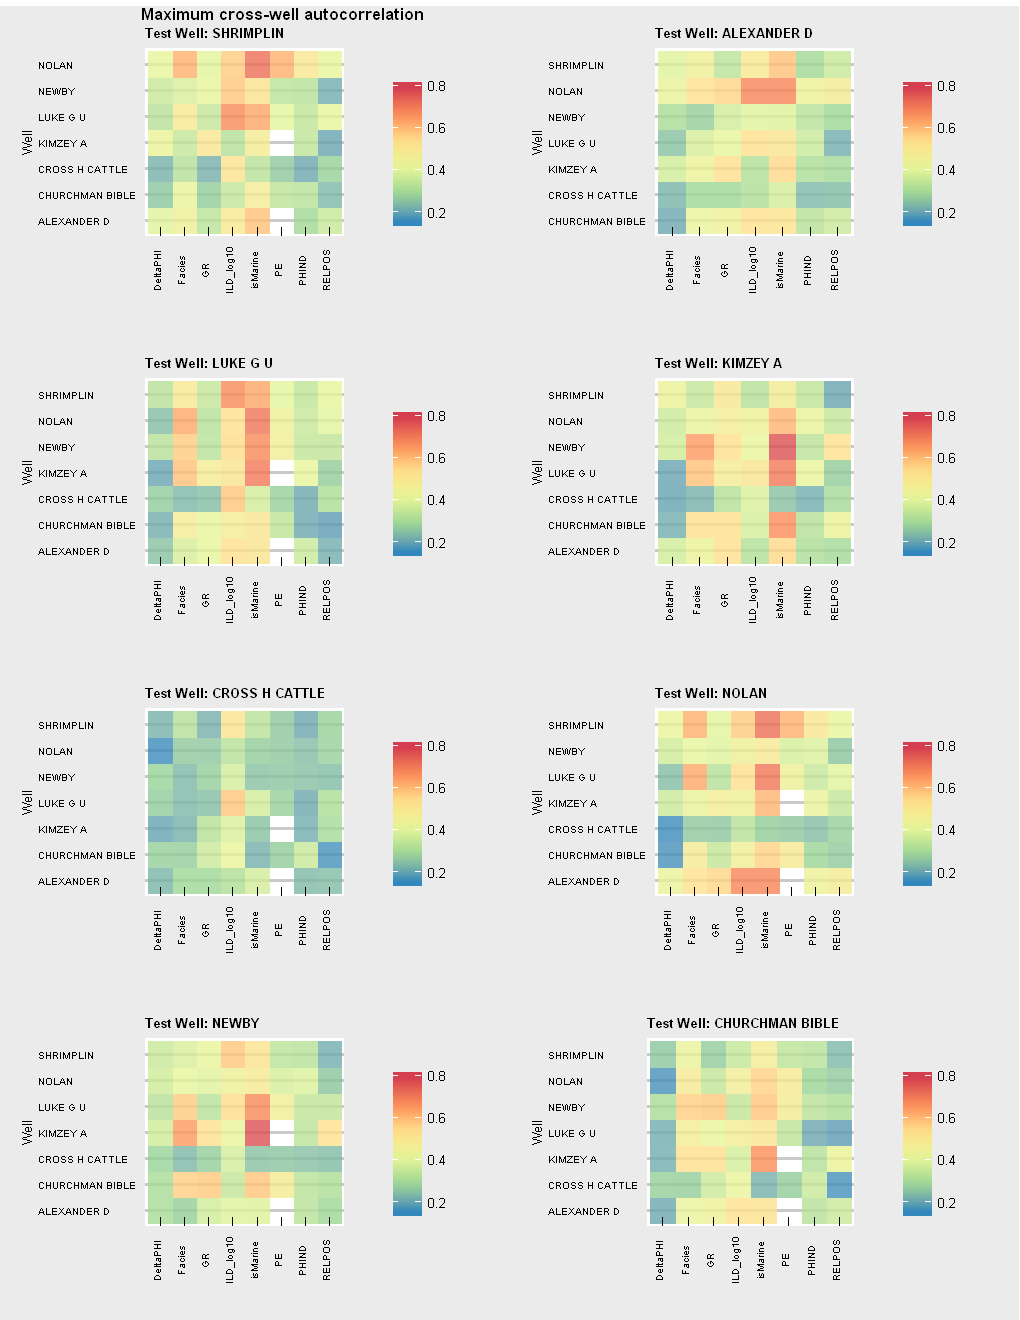

In [16]:
lagPlots <- list()
corrPlots <- list()

wells <- unique(weights$testWell)

for (well_i in wells) {
    subset <- weights[weights$testWell == well_i,]
    corrPlots[[well_i]] <- buildPlot(subset, paste("Test Well:", well_i))
}

options(repr.plot.width=8.5, repr.plot.height=11)
g <- do.call(plot_grid, c(corrPlots, ncol=2))
ggdraw() + draw_plot(g, width=1, height=1, y=-.005) + draw_plot_label("Maximum cross-well autocorrelation", size=10)

Looking more thoroughly at the data shows similar patterns as previously discussed.  The **isMarine** and **ILD_log10** features correlate strongest and the **CROSS H CATTLE** well is notably less correlative with the remaining wells.  

### 3.3 Build a basic model  

Now let's start doing some actual model building!  First I'll partition the data and use the **SHRIMPLIN** well as the test data, the remaining wells will act as training data.  

#### 3.3.1 Training a blended model  

Blended modeling is a practice where many models are built - and in the regression case averaged.  Our application is classification of **Facies** - so each model votes on a classification.  The classification with the most votes is assigned.  

For our application, we will build a predictive model for each well in the training set. The function which follows takes in the training data and returns a predictive model for each well in that training set.

In [58]:
trainBlendedModel <- function(data, testFeatures, method, ...) {

    # initialize model and params
    fits <- list()
    
    # retrieve list of wells in data set
    wells <- unique(data$Well.Name)
    
    fitControl <- trainControl(method="none")
    
    # loop through training wells
    for (well_i in wells) {
        # subset the data
        if (well_i == "Recruit F9") {
            #nRecruit <- nrow(data[data$Well.Name == well_i,])
            #nNon <- nrow(data[data$Well.Name != well_i,])
            #n <- nrow(data)
            
            #set.seed(1234)
            #include <- sample(c(T,F), nNon, replace=T, prob=c(nRecruit/nNon, (nNon-nRecruit)/nNon))
            #data_i <- rbind(data[data$Well.Name == well_i,], data[data$Well.Name != well_i,][include,])
            data_i <- data

        } else {
            data_i <- data[data$Well.Name == well_i,]
        }
        
        cols <- names(data_i) %in% whichFeatures(data_i, testFeatures)
        data_i <- data_i[,cols]
        
        # scale the data
        toScale <- !names(data_i) %in% c("Facies", "isMarine", "RELPOS")
        data_i_scaled <- centerScaleData(data_i, toScale)
        data_i_scaled$Facies <- factor(data_i_scaled$Facies)
        print(well_i)
        print(levels(data_i_scaled$Facies))
        print(table(data_i_scaled$Facies))
        # build the model for this well
        #fits[[well_i]] <- svm(Facies ~ ., data=data_i_scaled, kernel='radial', cost=cost, gamma=gamma, scale=F)
        fits[[well_i]] <- train(Facies ~ ., data=data_i_scaled, trControl=fitControl, method=method, cost=list(...)[["cost"]])
    }
    
    fits
}

#### 3.3.2 Weight a blended model  

blahblahblah

In [66]:
weightModel <- function(wells, lags, corrs, p) {
    # we want small lags and high correlations, so scale accordingly
    data <- data.frame(well=wells, lagscaled=lags/max(lags), corrscaled=(1-corrs))
    data$lag <- lags
    data$corr <- corrs
    
    # calculate the inverse distance weighting
    # distance is calculated in lag-correlation data space
    data$weight <- ((data$lagscaled^2 + data$corrscaled^2)^2)^(-p)
    
    # return well list and their respective model weights
    data[,-c(2,3)]
}

weightBlendedModel <- function(train, test, method="maxCorr", p=1, recruit_wgt=1) {
    
    # we need to treat Recruit F9 well differently, so let's parse it out
    trainRecruit <- train[train$Well.Name == "Recruit F9",]
    trainNon <- train[train$Well.Name != "Recruit F9",]
    
    # cross-correlate the test well with the training wells
    testFeatures <- names(test)[!is.na(test[1,])]
    cc <- crossCorrData(trainNon, test)
    
    # aggregate the cross-correlation results
    if (method == "maxCorr") {
        r <- data.frame()
        aggMax <- aggregate(correlation~trainWell, cc, FUN=max)
        trainWells <- unique(agg$trainWell)
        for (well_i in trainWells) {
            r <- rbind(r, cc[cc$trainWell == well_i & cc$correlation == aggMax$correlation[which(aggMax$trainWell==well_i)],])
        }        
    } else if (method == "singleFeature") {
        r <- cc[cc$feature=="isMarine",]
    } else if (method == "mean") {
        r <- aggregate(cbind(lag,correlation)~trainWell,data=cc,FUN=mean)    
    } else {
        r <- aggregate(cbind(lag, correlation)~trainWell, data=cc, FUN=median)
    }

    # calculate a weighting
    w <- weightModel(r$trainWell, r$lag, r$correlation, p)
    w <- rbind(w, data.frame(well="Recruit F9", lag=NA, corr=NA, weight=recruit_wgt))
    w
}

#### 3.3.3 Build a blended model  

Our blended model is essentially defined by the two previous functions.  Here we combine them into a single function object.

In [51]:
buildBlendedModel <- function(train, test, 
                              method="maxCorr",
                              cost, gamma, p=1, recruit_wgt=1) {
    
    # initialize the blended model
    blendedModel <- list()
    
    # weight the models
    blendedModel[["weights"]] <- weightBlendedModel(train, test, method=method, p, recruit_wgt)
    
    # lag the RELPOS channel
    wells <- blendedModel[["weights"]]$well[!blendedModel[["weights"]]$well %in% "Recruit F9"]
    for (well_i in wells) {
        df_i <- blendedModel[["weights"]]
        lag_i <- df_i[df_i$well == well_i,]$lag
        n_i <- nrow(train[train$Well.Name == well_i,])
        
        train[train$Well.Name == well_i,]$RELPOS <- train[train$Well.Name == well_i,]$RELPOS + lag_i / n_i
    }
    
    # train the models
    testFeatures <- names(test)[!is.na(test[1,])]
    blendedModel[["fits"]] <- trainBlendedModel(data=train, testFeatures=testFeatures, method="svmLinear", cost=cost)
    
    # return the blended model
    blendedModel
}

Now let's build a blended model.  For this example, we'll use **SHRIMPLIN** as our test well and the remaining training wells for training.

In [59]:
split <- splitData(train, "SHRIMPLIN")
atrain <- split[[1]]
atest <- split[[2]]

testFeatures <- names(atest)[!is.na(atest[1,])]
blendedModel <- buildBlendedModel(atrain, atest, method="maxCorr", cost=1, gamma=1, p=1, recruit_wgt=1)
print(blendedModel)

[1] "ALEXANDER D"
[1] "CSiS" "FSiS" "SiSh" "MS"   "WS"   "D"    "PS"   "BS"  

CSiS FSiS SiSh   MS   WS    D   PS   BS 
 117   91   44   26   69   16   98    5 
[1] "LUKE G U"
[1] "CSiS" "FSiS" "SiSh" "MS"   "WS"   "D"    "PS"  

CSiS FSiS SiSh   MS   WS    D   PS 
 117  129   35    2   84   20   74 
[1] "KIMZEY A"
[1] "SS"   "CSiS" "FSiS" "SiSh" "MS"   "WS"   "D"    "PS"   "BS"  

  SS CSiS FSiS SiSh   MS   WS    D   PS   BS 
   9   85   74   43   53   51   27   90    7 
[1] "CROSS H CATTLE"
[1] "SS"   "CSiS" "FSiS" "SiSh" "MS"   "WS"   "D"    "PS"  

  SS CSiS FSiS SiSh   MS   WS    D   PS 
 158  142   47   25   28   31    2   68 
[1] "NOLAN"
[1] "SS"   "CSiS" "FSiS" "SiSh" "MS"   "WS"   "D"    "PS"  

  SS CSiS FSiS SiSh   MS   WS    D   PS 
   4  118   68   28   47   30    4  116 
[1] "Recruit F9"
[1] "SS"   "CSiS" "FSiS" "SiSh" "MS"   "WS"   "D"    "PS"   "BS"  

  SS CSiS FSiS SiSh   MS   WS    D   PS   BS 
 179  733  540  246  214  448  119  577  173 
[1] "NEWBY"
[1] "CSiS" "FSi

But we haven't predicted anything yet.  In fact, we haven't even built our prediction function yet!  So let's build a function which takes in a blended model and test data - and predict the **facies**.

In [60]:
facies_colors <- c('#F4D03F', '#F5B041', '#DC7633', '#6E2C00', '#1B4F72', '#2E86C1', '#AED6F1', '#A569BD', '#196F3D')
facies_labels <- c('SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS')

# GR track - gamma ray
plotGR <- function(x, asWell=F) {
    g <- ggplot(x) + theme_economist_white(gray_bg=T) + 
        scale_y_continuous(lim=c(0,400), breaks=seq(0,400,100), labels=c("0"="0","100"="","200"="200","300"="","400"="400")) +
        scale_x_continuous(trans="reverse") + coord_flip() + labs(title="", x="Depth", y="GR") +
        geom_bar(stat="identity", data=x, aes(x=Depth, y=GR, fill=GR, alpha=0.5), width=0.5) +
        geom_line(aes(x=Depth, y=GR), lwd=.5, col='black') +
        scale_fill_continuous(limits=c(0,225), low="yellow", high="black") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.5), legend.position="none",
             axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"))
    if (asWell) {g <- g + labs(y=x$Well.Name[1])}
    if (asWell & x$Well.Name[1] != "CROSS H CATTLE") {g <- g + labs(x="")}
    g <- switch_axis_position(g, 'x')
    g
}

# ILD track - resistivity
plotILD <- function(x, asWell=F) {
    g <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_log10(lim=c(0.1,50), breaks=c(.1,.2,.4,.6,.8,1,2,4,6,8,10,20,40), 
                      labels=c(".1"=".1",".2"="",".4"="",".6"="",".8"="",
                               "1"="1","2"="","4"="","6"="","8"="","10"="10",
                              "20"="","40"="")) + 
        scale_x_continuous(trans="reverse") + 
        coord_flip() + labs(title="", x="", y="ILD") +
        geom_line(aes(x=Depth, y=10^ILD_log10), lwd=.5, col="skyblue4") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    if (asWell) {g <- g + labs(y=x$Well.Name[1]) + theme(axis.text.y=element_text(size=6))}
    if (asWell & x$Well.Name[1] == "CROSS H CATTLE") {g <- g + labs(x="Depth")}
    g <- switch_axis_position(g, 'x')
    g
}

# DeltaPhi track - difference between density and neutron porosities
plotDeltaPHI <- function(x, asWell=F) {
    g <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(-20,20), breaks=seq(-20,20,10),labels=c("-20"="-20","-10"="","0"="0","10"="","20"="20")) + 
        scale_x_continuous(trans="reverse") + coord_flip() + labs(title="", x="", y="DeltaPhi") +
        geom_line(aes(x=Depth, y=DeltaPHI), lwd=.5, col="seagreen4") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    if (asWell) {g <- g + labs(y=x$Well.Name[1]) + theme(axis.text.y=element_text(size=6))}
    if (asWell & x$Well.Name[1] == "CROSS H CATTLE") {g <- g + labs(x="Depth")}
    g <- switch_axis_position(g, 'x')
    g
}

# PHIND track - neutron porosity
plotPHIND <- function(x, asWell=F) {
    g <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(0,50), breaks=c(0,15,30,45)) + scale_x_continuous(trans="reverse") +
        coord_flip() + labs(title="", x="", y="PHIND") +
        geom_line(aes(x=Depth, y=PHIND), lwd=.5, col="firebrick") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    if (asWell) {g <- g + labs(y=x$Well.Name[1]) + theme(axis.text.y=element_text(size=6))}
    if (asWell & x$Well.Name[1] == "CROSS H CATTLE") {g <- g + labs(x="Depth")}
    g <- switch_axis_position(g, 'x')
    g
}

# PE track - photoelectric effect
plotPE <- function(x, asWell=F) {
    g <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(0,8), breaks=c(0,2,4,6,8)) + scale_x_continuous(trans="reverse") +
        coord_flip() + labs(title="", x="", y="PE") +
        geom_line(aes(x=Depth, y=PE), lwd=.5, col="black") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    if (asWell) {g <- g + labs(y=x$Well.Name[1]) + theme(axis.text.y=element_text(size=6))}
    if (asWell & x$Well.Name[1] == "SHRIMPLIN") {g <- g + labs(x="Depth")}
    g <- switch_axis_position(g, 'x')
    g
}

# isMarine track - indicator showing whether or not it's marine
plotIsMarine <- function(x, asWell=F) {
    x$ones <- rep(1, nrow(x))
    g <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(-0.1,1.1), breaks=c(0,1), labels=c("TRUE"="", "FALSE"="")) + 
        scale_x_continuous(trans="reverse") +
        coord_flip() + labs(title="", x="", y="isMarine") +
        geom_bar(stat="identity", data=x, aes(x=Depth, y=ones, fill=isMarine), width=0.5) +
        scale_fill_manual(values=c("TRUE"="springgreen3", "FALSE"="firebrick"), drop=F) +
        theme(axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank(), axis.text.x=element_text(size=6), 
              legend.position="none")
    if (asWell) {g <- g + labs(y=x$Well.Name[1]) + theme(axis.text.y=element_text(size=6))}
    if (asWell & x$Well.Name[1] == "CROSS H CATTLE") {g <- g + labs(x="Depth")}
    g <- switch_axis_position(g, 'x')
    g
}

# facies track
plotFacies <- function(x, asWell=F, withLegend=F) {
    x$ones <- rep(1, nrow(x))
    g <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(-0.1,1.1), breaks=c(0,1), labels=c("0"="", "1"="")) + scale_x_continuous(trans="reverse") +
        coord_flip() + labs(title="", x="", y="Facies") +
        geom_bar(stat="identity", data=x, aes(x=Depth, y=ones, fill=Facies), width=0.5) +
        scale_fill_manual(values=facies_colors, drop=F, labels=facies_labels) +
        theme(axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank(), axis.text.x=element_text(size=6), 
              legend.position="right", legend.text=element_text(size=6), legend.title=element_blank())
    if (asWell) {g <- g + labs(y=x$Well.Name[1]) + theme(axis.text.y=element_text(size=6))}
    if (asWell & x$Well.Name[1] == "CROSS H CATTLE") {g <- g + labs(x="Depth")}
    if (asWell & x$Well.Name[1] != "KIMZEY A" | !withLegend) {g <- g + theme(legend.position="none")}
    g <- switch_axis_position(g, 'x')
    g
}

# predicted facies track
plotPredict <- function(x, asWell=F) {
    x$ones <- rep(1, nrow(x))
    g <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(-0.1,1.1), breaks=c(0,1), labels=c("0"="", "1"="")) + scale_x_continuous(trans="reverse") +
        coord_flip() + labs(title="", x="", y="Predicted") +
        geom_bar(stat="identity", data=x, aes(x=Depth, y=ones, fill=Predicted), width=0.5) +
        scale_fill_manual(values=facies_colors, drop=F, labels=facies_labels) +
        theme(axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank(), axis.text.x=element_text(size=6), 
              legend.position="right", legend.text=element_text(size=6), legend.title=element_blank())
    if (asWell) {g <- g + labs(y=x$Well.Name[1]) + theme(axis.text.y=element_text(size=6))}
    if (asWell & x$Well.Name[1] == "CROSS H CATTLE") {g <- g + labs(x="Depth")}
    if (asWell & x$Well.Name[1] != "KIMZEY A") {g <- g + theme(legend.position="none")}
    g <- switch_axis_position(g, 'x')
    g
}

# for wells with PE track
logplot <- function(x, withPE=F, withPredict=F) {
    GR <- plotGR(x)
    ILD <- plotILD(x)
    deltaPHI <- plotDeltaPHI(x)
    PHIND <- plotPHIND(x)
    isMarine <- plotIsMarine(x)
    facies <- plotFacies(x, withLegend=!withPredict)
    
    if (withPE & !withPredict) {
        PE <- plotPE(x)
        g <- plot_grid(GR, ILD, deltaPHI, PHIND, PE, isMarine, facies, ncol=7, rel_widths=c(4,3,3,3,3,2,5))
    }
    else if (withPE & withPredict) {
        PE <- plotPE(x)
        predict <- plotPredict(x)
        g <- plot_grid(GR, ILD, deltaPHI, PHIND, PE, isMarine, facies, predict, ncol=8, rel_widths=c(4,3,3,3,3,3,2,5))
    }
    else if (!withPE & withPredict) {
        predict <- plotPredict(x)
        g <- plot_grid(GR, ILD, deltaPHI, PHIND, isMarine, facies, predict, ncol=7, rel_widths=c(4,3,3,3,3,2,5))
    }
    else {
        g <- plot_grid(GR, ILD, deltaPHI, PHIND, isMarine, facies, ncol=6, rel_widths=c(4,3,3,3,2,5))
    }
    
    ggdraw() + draw_plot(g, width=1, height=1) + draw_plot_label(x$Well.Name[1], size=10)
}

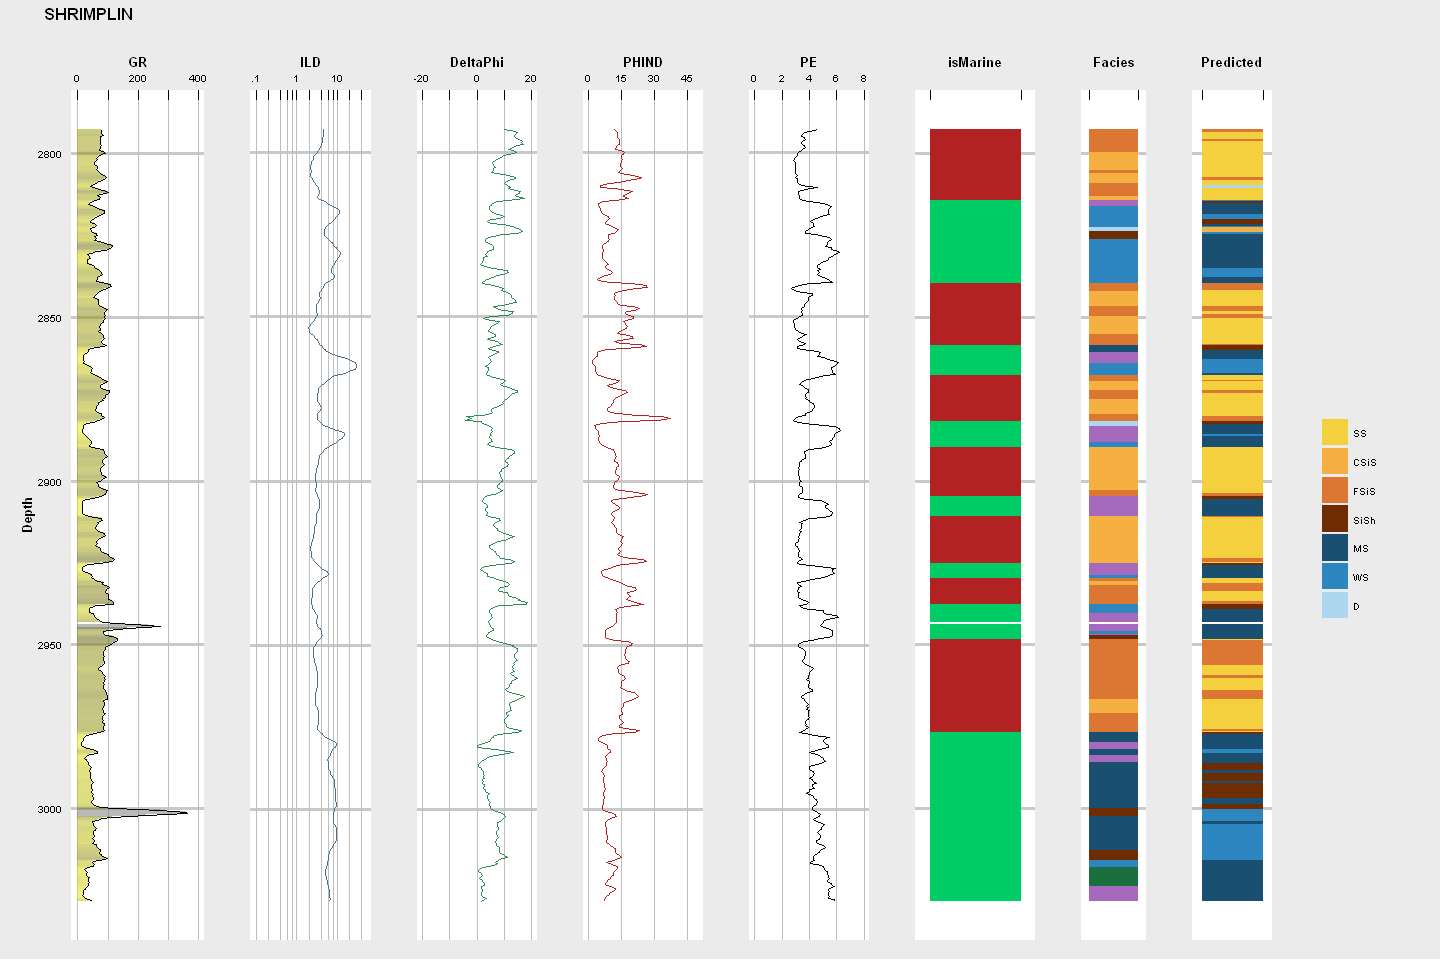

In [61]:
tallyVotes <- function(test, blendedModel, classes) {
    wells <- names(blendedModel[["fits"]])
    
    # initialize data frame for weighted vote tallies with zeros
    votes <- data.frame(matrix(0, nrow = nrow(test), ncol = length(classes)))
    names(votes) <- classes
    
    for (well_i in wells) {
        predictions <- predict(blendedModel[["fits"]][[well_i]], newdata=test)
        
        for (i in 1:nrow(test)) {
            # retrieve the weight to be added
            df <- blendedModel[["weights"]]
            w <- df[df$well == well_i, 4]
            
            # add well weight
            votes[i, which(names(votes) %in% predictions[i])] <- votes[i, which(names(votes) %in% predictions[i])] + w
        }
    }
    
    votes
}

electClass <- function(test, votes) {

    for (i in 1:nrow(test)) {
        test$Predicted[i] <- names(votes)[which.max(votes[i,])]
    }
    
    test$Predicted
}

predictBlendedModel <- function(test, blendedModel, classes) {
    
    testFeatures <- names(test)[!is.na(test[1,])]
    testFeatures <- testFeatures[!testFeatures %in% c("Facies", "Formation", "Well.Name", "Depth", "isMarine", "RELPOS")]
    testToScale <- names(test) %in% testFeatures
    
    test_scaled <- centerScaleData(test, testToScale)
    
    votes <- tallyVotes(test_scaled, blendedModel, classes)
    test$Predicted <- electClass(test_scaled, votes)
    
    test
    
}

classes <- levels(data$Facies)
test_predict <- predictBlendedModel(atest, blendedModel, classes)

options(repr.plot.width=12, repr.plot.height=8)
logplot(test_predict, TRUE, TRUE)

Our prediction qualitatively looks pretty bad - but we have a lot of tuning to improve it!  It does seem to do a decent job of picking up boundaries - so there's hope!  Now we need to quantitatively evaluate the model - so let's build some metrics!

In [62]:
accuracy_metrics <- function(cm, ytrue) {
    
    # initialize vectors for precision, recall, and f1 metrics with zeros
    prec <- rep(0,9)
    recall <- rep(0,9)
    f1 <- rep(0,9)

    # loop through facies to compute precision, recall, and f1 for each facies
    beta <- 1
    for (i in 1:9) {
        prec[i] <- cm[i,i] / sum(cm[i,])
        recall[i] <- cm[i,i] / sum(cm[,i])
        f1[i] <- (1 + beta^2) * prec[i] * recall[i] / ((beta^2 * prec[i]) + recall[i])
    }
    
    prec[is.na(prec)] <- 0
    recall[is.na(recall)] <- 0
    f1[is.na(f1)] <- 0
    
    support <- as.matrix(table(ytrue))
    tot_precision <- sum(prec * support) / sum(support)
    tot_recall <- sum(recall * support) / sum(support)
    tot_f1 <- sum(f1 * support) / sum(support)
    
    c(tot_precision, tot_recall, tot_f1)
}

eval_model <- function(ypred, ytrue) {
    cm <- confusionMatrix(ypred, ytrue)
    accuracy_metrics(as.matrix(cm[["table"]]), ytrue)
}

In [63]:
print(head(test_predict))
metrics <- eval_model(test_predict$Predicted, test_predict$Facies)
print(metrics)

  Facies Formation Well.Name  Depth    GR ILD_log10 DeltaPHI  PHIND  PE
1   FSiS     A1 SH SHRIMPLIN 2793.0 77.45     0.664      9.9 11.915 4.6
2   FSiS     A1 SH SHRIMPLIN 2793.5 78.26     0.661     14.2 12.565 4.1
3   FSiS     A1 SH SHRIMPLIN 2794.0 79.05     0.658     14.8 13.050 3.6
4   FSiS     A1 SH SHRIMPLIN 2794.5 86.10     0.655     13.9 13.115 3.5
5   FSiS     A1 SH SHRIMPLIN 2795.0 74.58     0.647     13.5 13.300 3.4
6   FSiS     A1 SH SHRIMPLIN 2795.5 73.97     0.636     14.0 13.385 3.6
  isMarine RELPOS Predicted
1    FALSE  1.000      FSiS
2    FALSE  0.979      FSiS
3    FALSE  0.957      CSiS
4    FALSE  0.936      CSiS
5    FALSE  0.915      CSiS
6    FALSE  0.894      CSiS


Warning message in levels(reference) != levels(data):
"longer object length is not a multiple of shorter object length"Warning message in confusionMatrix.default(ypred, ytrue):
"Levels are not in the same order for reference and data. Refactoring data to match."

[1] 0.5478021 0.5477707 0.4971655


So we have an overall F1-Score of 0.4971655 - not bad without tuning. Now let's move forward to tuning!

## Model tuning  

Blahblahblah

In [64]:
buildAndEval <- function(train, test, well, classes, agg_method, p, recruit_wgt, train_method, ...) {
    
    # build blended model
    blendedModel <- buildBlendedModel(train, test, 
                                      method=method, cost=cost, gamma=gamma, 
                                      p=p, recruit_wgt=recruit_wgt)

    # predict facies
    test_predict <- predictBlendedModel(test, blendedModel, classes)

    # calculate metrics
    em <- eval_model(test_predict$Predicted, test_predict$Facies)

    # store and return results
    temp <- data.frame(well=well, method=method, cost=cost, gamma=gamma, 
                       p=p, recruit_wgt=recruit_wgt, 
                       precision=em[1], recall=em[2], f1=em[3])
    temp
}

# function to tune model
# default parameters manually selected - mostly over decades
tuneBlendedModel <- function(data, 
                             costs=c(1, 10, 25),
                             gammas=c(.01, .1, 1),
                             ps=c(.1, 1, 10),
                             wgts=c(.1, 1, 10)) {
    
    # retrieve list of wells in data set
    wells <- unique(data$Well.Name)
    wells <- wells[!wells %in% "Recruit F9"]
    classes <- levels(data$Facies)
    
    # tuning parameters
    methods <- c("maxCorr", "singleFeature", "mean", "median")
    
    results <- data.frame()
    
    # loop through wells
    for (well_i in wells) {
        
        # split data into training and test (well_i is test)
        split <- splitData(data, well_i)
        atrain <- split[[1]]
        atest <- split[[2]]
        
        for (method_i in methods) {
            for (cost_i in costs) {
                for (gamma_i in gammas) {
                    for (p_i in ps) {
                        for (wgt_i in wgts) {
                            results <- rbind(results,
                                            buildAndEval(atrain, atest, well_i, classes,
                                                        method_i, cost_i, gamma_i, p_i, wgt_i))
                        }
                    }
                }
            }
        }
    }
    
    results
}

In [65]:
# execute model tuning, print the model tuning parameters
options(warn=-1)
tune <- tuneBlendedModel(train)
print(tune)

[1] "ALEXANDER D"
[1] "CSiS" "FSiS" "SiSh" "MS"   "WS"   "D"    "PS"   "BS"  

CSiS FSiS SiSh   MS   WS    D   PS   BS 
 117   91   44   26   69   16   98    5 
[1] "LUKE G U"
[1] "CSiS" "FSiS" "SiSh" "MS"   "WS"   "D"    "PS"  

CSiS FSiS SiSh   MS   WS    D   PS 
 117  129   35    2   84   20   74 
[1] "KIMZEY A"
[1] "SS"   "CSiS" "FSiS" "SiSh" "MS"   "WS"   "D"    "PS"   "BS"  

  SS CSiS FSiS SiSh   MS   WS    D   PS   BS 
   9   85   74   43   53   51   27   90    7 
[1] "CROSS H CATTLE"
[1] "SS"   "CSiS" "FSiS" "SiSh" "MS"   "WS"   "D"    "PS"  

  SS CSiS FSiS SiSh   MS   WS    D   PS 
 158  142   47   25   28   31    2   68 
[1] "NOLAN"
[1] "SS"   "CSiS" "FSiS" "SiSh" "MS"   "WS"   "D"    "PS"  

  SS CSiS FSiS SiSh   MS   WS    D   PS 
   4  118   68   28   47   30    4  116 
[1] "Recruit F9"
[1] "SS"   "CSiS" "FSiS" "SiSh" "MS"   "WS"   "D"    "PS"   "BS"  

  SS CSiS FSiS SiSh   MS   WS    D   PS   BS 
 179  733  540  246  214  448  119  577  173 
[1] "NEWBY"
[1] "CSiS" "FSi

ERROR: Error in na.fail.default(structure(list(Facies = structure(c(3L, 3L, 3L, : missing values in object


In [187]:
#print("By method:")
#print(aggregate(cbind(precision, recall, f1)~method, data=r, mean))

#print("By Cost:")
#print(aggregate(cbind(precision, recall, f1)~cost, data=r, mean))

#print("By Gamma:")
#print(aggregate(cbind(precision, recall, f1)~gamma, data=r, mean))

#print("By p:")
#print(aggregate(cbind(precision, recall, f1)~p, data=r, mean))

#print("By Recruit F9 weight:")
#print(aggregate(cbind(precision, recall, f1)~recruit_wgt, data=r, mean))
temp <- by(data=tune$f1, list(method=tune$method, 
                      cost=as.factor(tune$cost), 
                      gamma=as.factor(tune$gamma),
                      p=as.factor(tune$p),
                      recruit_wgt=as.factor(tune$recruit_wgt)), mean)

nm <- dimnames(temp)
results <- data.frame() 

for (i in 1:length(nm[[1]])) {
    for (j in 1:length(nm[[2]])) {
        for (k in 1:length(nm[[3]])) {
            for (l in 1:length(nm[[4]])) {
                for (m in 1:length(nm[[5]])) {
                    t <- data.frame(method=nm[[1]][i], cost=nm[[2]][j], gamma=nm[[3]][k], p=nm[[4]][l], recruit_wgt=nm[[5]][m], 
                                   f1=temp[[nm[[1]][i], nm[[2]][j], nm[[3]][k], nm[[4]][l], nm[[5]][m]]])
                    results <- rbind(results, t)
                }
            }
        }
    }
}

results[which.max(results$f1),]

,method,cost,gamma,p,recruit_wgt,f1
298,median,25,0.01,0.1,0.1,0.5127984


In [148]:
# best numbers above:
#   method: median
#   cost: 25
#   gamma: 0.01
#   p: 0.1
#   recruit_wgt: 0.1
# Let's try and improve them with a finer search
costs <- c(20, 25, 30)
gammas <- c(.005, .01, .05)
ps <- c(.05,.1,.5)
wgts <- c(.05,.1,.5)

tune2 <- tuneBlendedModel(train, costs, gammas, ps, wgts)

In [186]:
temp <- by(data=tune2$f1, list(method=tune2$method, 
                      cost=as.factor(tune2$cost), 
                      gamma=as.factor(tune2$gamma),
                      p=as.factor(tune2$p),
                      recruit_wgt=as.factor(tune2$recruit_wgt)), mean)

nm <- dimnames(temp)
results <- data.frame() 

for (i in 1:length(nm[[1]])) {
    for (j in 1:length(nm[[2]])) {
        for (k in 1:length(nm[[3]])) {
            for (l in 1:length(nm[[4]])) {
                for (m in 1:length(nm[[5]])) {
                    t <- data.frame(method=nm[[1]][i], cost=nm[[2]][j], gamma=nm[[3]][k], p=nm[[4]][l], recruit_wgt=nm[[5]][m], 
                                   f1=temp[[nm[[1]][i], nm[[2]][j], nm[[3]][k], nm[[4]][l], nm[[5]][m]]])
                    results <- rbind(results, t)
                }
            }
        }
    }
}
#temp[["maxCorr", "20", "0.005", "0.05", "0.05"]]
#temp
results[which.max(results$f1),]

,method,cost,gamma,p,recruit_wgt,f1
283,median,25,0.01,0.1,0.05,0.5128927


## Training  

Blahblahblah

In [6]:
# function to train model

In [7]:
# execute model training

## Testing  

Blahblahblah

In [8]:
# function to test model (on SHANKLE well)

In [9]:
# execute model testing

## Conclusions  

Blahblahblah